<a href="https://colab.research.google.com/github/EzraMW/ML/blob/main/Ezra_Wildes_20_newsgroups.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From: https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html
Also, great explanation at: 
https://krakensystems.co/blog/2018/text-classification

For now, we'll use the training dataset built into Sklearn. 

In [1]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
newsgroups_train_full = fetch_20newsgroups(subset='train')
#newsgroups_test = fetch_20newsgroups(subset='test')

In [2]:
from pprint import pprint
pprint(list(newsgroups_train_full.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


Now, we need to create the vectors needed for classifications. To make things easier (faster) we'll limit ourselves to only a few categories. From the shape function, try to understand how many features there are in the dataset, and how many records are in the train / test datasets.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer 
cats = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train', categories=cats)
newsgroups_test = fetch_20newsgroups(subset='test',  categories=cats)
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors.shape

(2034, 34118)

In [4]:
vectors_test = vectorizer.transform(newsgroups_test.data)
vectors_test.shape

(1353, 34118)

We'll first use the Multinomial NB classifier as it's the fastest (do you know why?).

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
clf = MultinomialNB()
clf.fit(vectors, newsgroups_train.target)
pred = clf.predict(vectors_test)
metrics.f1_score(newsgroups_test.target, pred, average='macro')

0.7924374490634268

There is an alpha parameter in NB that controls the strength of the smoothing. If alpha is zero we will have the 0 probability problem we talked about it class. As alpha increases, the likelihood probability moves towards uniform distribution (0.5), so a smaller value of alpha is likely better, but a very small value will put more weight for less frequent words (a type of feature selection).  This formula is discussed at:
https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece

and we talked about it in class:
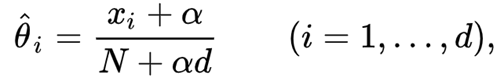

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
for value in [10, 1, 0.01, 0.001, 0.0001, 0]:
  clf = MultinomialNB(alpha=value)
  clf.fit(vectors, newsgroups_train.target)
  pred = clf.predict(vectors_test)
  print(metrics.f1_score(newsgroups_test.target, pred, average='macro'))

0.6144072995178805
0.7924374490634268
0.8821359240272957
0.8808325045824638
0.8746771093948736
0.8660426652791797


/usr/local/lib/python3.8/dist-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


First, note that we use macro metrics for the score (f1).  The difference between macro and micro is: macro averaging gives equal weight to each category while micro averaging gives equal weight to each sample (take from Wikipedia). 
The alpha values are one example of a hyperparameter optimization. 
However, it is quite hard to understand *why* these values of alpha improved performance.
Let's use feature selection instead.  First, let's try to see what features have the highest feature count (frequency or tf). 

In [7]:
import numpy as np
def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names_out())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.feature_log_prob_[i])[-10:]
        print("%s: %s" % (category, " ".join(feature_names[top10])))
show_top10(clf, vectorizer, newsgroups_train.target_names)

alt.atheism: edu it and in you that is of to the
comp.graphics: edu in graphics it is for and of to the
sci.space: edu it that is in and space to of the
talk.religion.misc: not it you in is that and to of the


As you can see, the most popular words are the same and in some cases stopwords (is, it, and, etc.).  How can we change this?  Take a look at:
https://krakensystems.co/blog/2018/text-classification
You can see some nice code about how to create vectors without the stopwords. 

In [8]:
#from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words=stopwords)
#print(vectorizer)
vectorizer.fit(newsgroups_train.data)
vectors = vectorizer.transform(newsgroups_train.data)
print(vectors.shape)

(2034, 33977)


In [10]:
vectors_test = vectorizer.transform(newsgroups_test.data)
vectors_test.shape

(1353, 33977)

Did taking out the stopwords help?  Let's find out!

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
for value in [10, 1, 0.01, 0.001, 0.0001, 0]:
  clf = MultinomialNB(alpha=value)
  clf.fit(vectors, newsgroups_train.target)
  pred = clf.predict(vectors_test)
  print(metrics.f1_score(newsgroups_test.target, pred, average='macro'))

0.8514764472563041
0.8866387019415313
0.8863490220370683
0.8827427087688202
0.8781168062845757
0.8691516834411483


/usr/local/lib/python3.8/dist-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Let's see how the top ten words looks now!

In [12]:
show_top10(clf, vectorizer, newsgroups_train.target_names)

alt.atheism: organization would lines subject com writes people one god edu
comp.graphics: file posting university com image organization graphics subject lines edu
sci.space: article writes com would lines organization subject nasa edu space
talk.religion.misc: lines would jesus organization people subject one god com edu


As you can see, unfortunately, some words seem to overfit the model (like com and subject). These are artifacts from the fact that this is an email corpose. We can take these out...

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer 
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),categories=cats)

newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),categories=cats)
vectorizer = CountVectorizer(stop_words=stopwords)
vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)
vectors_test = vectorizer.transform(newsgroups_test.data)
print(vectors_test.shape)

(2034, 26739)
(1353, 26739)


Let's see how the accuracy is now!

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
for value in [10, 1, 0.01, 0.001, 0.0001, 0]:
  clf = MultinomialNB(alpha=value)
  clf.fit(vectors, newsgroups_train.target)
  pred = clf.predict(vectors_test)
  print(metrics.f1_score(newsgroups_test.target, pred, average='macro'))

0.7146613383458164
0.7677138606860464
0.7511496058759426
0.7517360304585499
0.7409593995532573
0.7278885444867065


/usr/local/lib/python3.8/dist-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Blah! The overfitted features helped more than we would have liked!!!

Out of curiousity, how about seeing a confusion matrix!

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cm = confusion_matrix(newsgroups_test.target, pred)
print("Confusion matrix:")
print(cm)
print()
print(classification_report(newsgroups_test.target, pred, target_names=cats))

Confusion matrix:
[[206   6  42  65]
 [  7 340  40   2]
 [ 16  17 350  11]
 [ 86   6  34 125]]

                    precision    recall  f1-score   support

       alt.atheism       0.65      0.65      0.65       319
talk.religion.misc       0.92      0.87      0.90       389
     comp.graphics       0.75      0.89      0.81       394
         sci.space       0.62      0.50      0.55       251

          accuracy                           0.75      1353
         macro avg       0.74      0.73      0.73      1353
      weighted avg       0.75      0.75      0.75      1353



Now let's try to understand what you got!  What were the 20 most important words overall?

In [16]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
#from sklearn.feature_selection import chi2
# compute chi2 for each feature
chi2score = chi2(vectors, newsgroups_train.target)[0]
wscores = zip(vectorizer.get_feature_names_out(),chi2score)

In case you were wondering (like I was) why we need the subscript [0] up above, it is because the Chi functions returns both the rank and the p-values in the test. See: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2

In [17]:
print("Overall")
wchi2 = sorted(wscores,key=lambda x:x[1],reverse = True) 
for i in range(0,20):
    print(wchi2[i])

Overall
('space', 2114.3291993638345)
('image', 1002.3573689042399)
('graphics', 1000.3151101745898)
('god', 972.1333339908729)
('nasa', 739.6052005383311)
('jesus', 696.9986217061318)
('jpeg', 649.7098818406524)
('launch', 631.4282493202596)
('atheism', 614.5291005693214)
('file', 557.1821472367847)
('atheists', 504.45345546642807)
('orbit', 471.13167222112975)
('lunar', 442.2630691399662)
('shuttle', 437.25528950511523)
('bible', 431.3096419334133)
('christian', 408.54496246001946)
('satellite', 402.66432930421126)
('files', 391.2249057712174)
('ra', 390.3976582454005)
('color', 382.5549737110668)


Question #1: Repeat this with the other 2 univariate feature selection methods -- Mutual Information (information gain) and 
ANOVA (f-classifier).  What did you get?

**Mutual Information**

In [18]:
mutual_info = mutual_info_classif(vectors, newsgroups_train.target)
# print(mutual_info)
mscores = zip(vectorizer.get_feature_names_out(), mutual_info)
# print(mscores)
print("Mutual Info Scores:")
ms = sorted(mscores, key=lambda x:x[1], reverse=True)
for i in range(20):
  print(ms[i])

Mutual Info Scores:
('space', 0.1173236239203111)
('god', 0.08240250725184692)
('graphics', 0.08049773882433058)
('nasa', 0.0554899591549844)
('jesus', 0.053335197282894695)
('bible', 0.050045152330884676)
('religion', 0.04976531130996309)
('orbit', 0.04918436713613978)
('people', 0.04861661784666314)
('thanks', 0.04463381475170024)
('christian', 0.04404773236194079)
('launch', 0.04277924010634877)
('program', 0.04084815955227174)
('christians', 0.03895386885667451)
('shuttle', 0.03786743703272834)
('moon', 0.037685026613542214)
('atheism', 0.036343922682811135)
('file', 0.03534148343611539)
('files', 0.035054492237774494)
('religious', 0.0350036736698566)


**Anova**

In [19]:
anova = f_classif(vectors, newsgroups_train.target)[0]
print(anova)
ascores = zip(vectorizer.get_feature_names_out(), anova)
print(ascores)
print("Anova Scores:")
asc = sorted(ascores, key=lambda x:x[1], reverse=True)
for i in range(20):
  print(asc[i])

[4.18427422 4.18380592 1.62229687 ... 0.80977825 0.80977825 1.65767294]
Anova Scores:
('thanks', 62.79685404745179)
('hi', 47.936836481731625)
('space', 31.89761590649267)
('advance', 28.286035831641602)
('orbit', 27.30216275449487)
('christ', 27.24572163878179)
('agree', 27.17352936492761)
('say', 26.910524680375456)
('christian', 26.577991593603347)
('christians', 26.46442467256579)
('vga', 25.793402747097826)
('fact', 25.189140586267186)
('people', 25.090558682171466)
('kent', 24.669941573460623)
('god', 23.451134235477326)
('bible', 22.979619229999773)
('flight', 22.666585696662853)
('card', 21.913999014262398)
('earth', 21.664469458399893)
('appreciated', 21.60735197713781)


In [24]:
import pandas as pd
pd.DataFrame(data = [wchi2, ms, asc], index=["Chi2", "Mutual Information", "Anova"]).T

,Chi2,Mutual Information,Anova
0,"(space, 2114.3291993638345)","(space, 0.1173236239203111)","(thanks, 62.79685404745179)"
1,"(image, 1002.3573689042399)","(god, 0.08240250725184692)","(hi, 47.936836481731625)"
2,"(graphics, 1000.3151101745898)","(graphics, 0.08049773882433058)","(space, 31.89761590649267)"
3,"(god, 972.1333339908729)","(nasa, 0.0554899591549844)","(advance, 28.286035831641602)"
4,"(nasa, 739.6052005383311)","(jesus, 0.053335197282894695)","(orbit, 27.30216275449487)"
...,...,...,...
26734,"(requirement, 0.10189992834820985)","(walking, 3.1892130978726074e-05)","(requirement, 0.03411962475817572)"
26735,"(task, 0.09291617067725984)","(wrapped, 3.1892130978726074e-05)","(task, 0.03112681568125329)"
26736,"(accuracy, 0.08494945803459115)","(requirement, 2.6114265878325257e-05)","(accuracy, 0.028415660157358046)"
26737,"(count, 0.07797706262751433)","(task, 2.2471348333280225e-05)","(count, 0.0221537508328002)"


The top 20 words using anova appear to be signifanctly different from the lists using chi2 and mutual information

Question #2: Does using feature features help or hurt the performance of the model? Note that we have a lot of features here!  Try making a graph of the performance (f1 or whatever) with the top 1000...27000 (about) features.

I will be using the top words acheived by the anova classifier

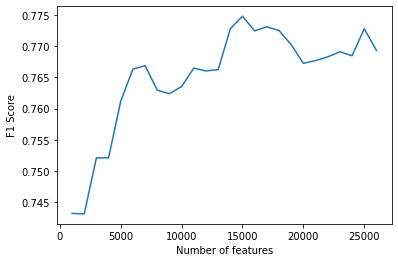

In [28]:
n_features = list(range(1000, 27000, 1000))
f1_scores = []
for n in n_features:
    words = asc[:n]
    vocab = list(zip(*words))[0]
    vectorizer = TfidfVectorizer(vocabulary=vocab)
    vectors = vectorizer.fit_transform(newsgroups_train.data)
    targets = newsgroups_train.target
    vectors_test = vectorizer.transform(newsgroups_test.data)
    model = MultinomialNB(alpha=.01)
    model.fit(vectors, targets)
    pred = model.predict(vectors_test)
    f1 = metrics.f1_score(newsgroups_test.target, pred, average='macro')
    f1_scores.append(f1)

plt.plot(n_features, f1_scores)
plt.xlabel("Number of features")
plt.ylabel("F1 Score")
plt.show()

I have a similar file with a different dataset here:
https://colab.research.google.com/drive/1ArYAcpSMiYEDe08uXh1SYyeo-uMEURFf?usp=sharing 

Question #3: Does adding stemming help?  How about taking out special formatting?  How about making everything lower_case?
Some nice examples of similar projects exist at:
 https://krakensystems.co/blog/2018/text-classification and 
 
https://github.com/screddy1313/Text-Classification-with-20news-dataset/blob/master/code/MultiClassNB.ipynb. 
 
Hint: try things like: 
 
CountVectorizer(lowercase=True,stop_words=stopwords)

In [29]:
# Note: taken from https://krakensystems.co/blog/2018/text-classification
from nltk.stem import PorterStemmer
from nltk import word_tokenize
nltk.download('punkt')

def stemming_tokenizer(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in word_tokenize(text)]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


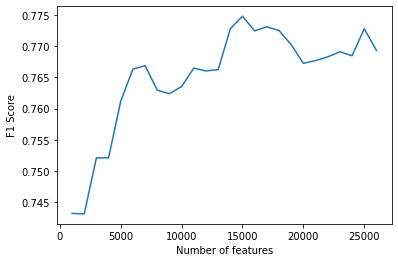

In [30]:
n_features = list(range(1000, 27000, 1000))
f1_scores = []
for n in n_features:
    words = asc[:n]
    vocab = list(zip(*words))[0]
    vectorizer = TfidfVectorizer(vocabulary=vocab, stop_words=stopwords)
    # vectorizer = TfidfVectorizer(vocabulary=vocab, stop_words=stopwords, tokenizer=stemming_tokenizer)
    # vectorizer = CountVectorizer(vocabulary=vocab)
    vectors = vectorizer.fit_transform(newsgroups_train.data)
    targets = newsgroups_train.target
    vectors_test = vectorizer.transform(newsgroups_test.data)
    model = MultinomialNB(alpha=.01)
    model.fit(vectors, targets)
    pred = model.predict(vectors_test)
    f1 = metrics.f1_score(newsgroups_test.target, pred, average='macro')
    f1_scores.append(f1)

plt.plot(n_features, f1_scores)
plt.xlabel("Number of features")
plt.ylabel("F1 Score")
plt.show()

Most of the changes I tried did not make much of a difference. However, when I tried changing the normalization from l2 to l1, as the number of features got larger the model performed significantly worse. Using a count vectorizer made it perform slightly worse. Setting the parameters to adjust lowercase, stripping accents, binary ("sets all non-zero term count to 1") even lemmatizing, all didn't help, but also didn't significantly hurt, the f1 score.


Question #4: Does using a different learning model, like Random Forest help?  Note that Random Forest is slower, so you might want to try it with fewer features!

Try to understand the code at:
https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py

I once made up a simpler example for the Iris dataset at:

https://colab.research.google.com/drive/1XdShFSTiQqYPPTeBxQ2HcfwqHiyxXoBa?usp=sharing


In [32]:
from sklearn.ensemble import RandomForestClassifier

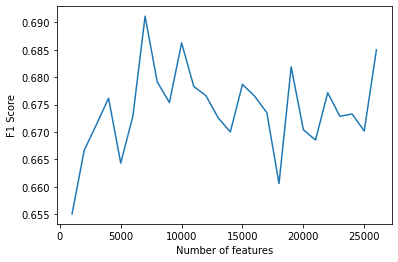

In [33]:
n_features = list(range(1000, 27000, 1000))
f1_scores = []
for n in n_features:
    words = asc[:n]
    vocab = list(zip(*words))[0]
    vectorizer = TfidfVectorizer(vocabulary=vocab, stop_words=stopwords)
    # vectorizer = TfidfVectorizer(vocabulary=vocab, stop_words=stopwords, tokenizer=stemming_tokenizer)
    # vectorizer = CountVectorizer(vocabulary=vocab)
    vectors = vectorizer.fit_transform(newsgroups_train.data)
    targets = newsgroups_train.target
    vectors_test = vectorizer.transform(newsgroups_test.data)
    # model = MultinomialNB(alpha=.01)
    model = RandomForestClassifier(n_estimators=100, criterion='entropy')
    model.fit(vectors, targets)
    pred = model.predict(vectors_test)
    f1 = metrics.f1_score(newsgroups_test.target, pred, average='macro')
    f1_scores.append(f1)

plt.plot(n_features, f1_scores)
plt.xlabel("Number of features")
plt.ylabel("F1 Score")
plt.show()

Using a Random Forrest Classifier, instead of the Multinomial Naive Bayes model, actually made the model do worse, even after changing the criterion from gini to entropy

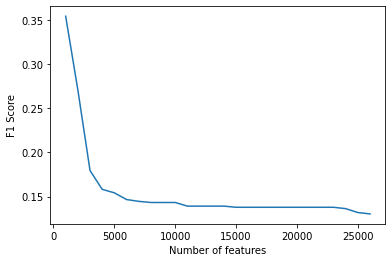

In [37]:
from sklearn.neighbors import KNeighborsClassifier
n_features = list(range(1000, 27000, 1000))
f1_scores = []
for n in n_features:
    words = asc[:n]
    vocab = list(zip(*words))[0]
    vectorizer = TfidfVectorizer(vocabulary=vocab, stop_words=stopwords)
    # vectorizer = TfidfVectorizer(vocabulary=vocab, stop_words=stopwords, tokenizer=stemming_tokenizer)
    # vectorizer = CountVectorizer(vocabulary=vocab)
    vectors = vectorizer.fit_transform(newsgroups_train.data)
    targets = newsgroups_train.target
    vectors_test = vectorizer.transform(newsgroups_test.data)
    # model = MultinomialNB(alpha=.01)
    model = KNeighborsClassifier(n_neighbors=3)
    model.fit(vectors, targets)
    pred = model.predict(vectors_test)
    f1 = metrics.f1_score(newsgroups_test.target, pred, average='macro')
    f1_scores.append(f1)

plt.plot(n_features, f1_scores)
plt.xlabel("Number of features")
plt.ylabel("F1 Score")
plt.show()

Using K-Neighbors classifier performed horribly whether using 3, 5, or 30 nearest neighbors

Question #5: Challenge Question (not needed for next week):

What were the words that are special to each of the categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
Note that the CHI2 and other rankings are GLOBAL.  I would like to see the important words within each of the categories.  This is the difference between Mutual Information (MI) and Pointwise Mutual Information (PMI).  
Hint: you might want to do some preprocessing. We’ll discuss in class.

In [ ]:
#Enter code here